In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

# NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lavz1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lavz1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lavz1\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# load  dataset
df = pd.read_csv('data1.csv')
print("Initial dataset shape:", df.shape)
df = df.drop_duplicates(subset=['Review Text'])
print("After removing duplicates:", df.shape)
print("\nRaw sentiment counts before any filtering:")
print(df['Review Text'].apply(label_sentiment).value_counts())


Initial dataset shape: (5000, 3)
After removing duplicates: (4052, 3)

Raw sentiment counts before any filtering:
Review Text
neutral     3437
positive     511
negative     104
Name: count, dtype: int64


In [ ]:
def label_sentiment(text):
    text = str(text).lower()
    positive_words = ['good', 'great', 'excellent', 'awesome', 'love', 
                     'nice', 'perfect', 'best', 'happy', 'recommend']
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst',
                     'disappointed', 'waste', 'not good', 'broken']
    
    pos_count = sum(1 for word in positive_words if re.search(rf'\b{word}\b', text))
    neg_count = sum(1 for word in negative_words if re.search(rf'\b{word}\b', text))
    
    if pos_count > 0 and pos_count > neg_count:
        return 'positive'
    elif neg_count > 0 and neg_count > pos_count:
        return 'negative'
    return 'neutral'

df['sentiment'] = df['Review Text'].apply(label_sentiment)
print("\nBefore filtering:")
print(df['sentiment'].value_counts())


Before filtering:
sentiment
neutral     3437
positive     511
negative     104
Name: count, dtype: int64


In [ ]:
value_counts = df['sentiment'].value_counts()
valid_classes = value_counts[value_counts >= 1].index 
df = df[df['sentiment'].isin(valid_classes)]

print("\nAfter filtering:")
print(df['sentiment'].value_counts())
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


After filtering:
sentiment
neutral     3437
positive     511
negative     104
Name: count, dtype: int64


In [ ]:

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_review'] = df['Review Text'].apply(preprocess_text)


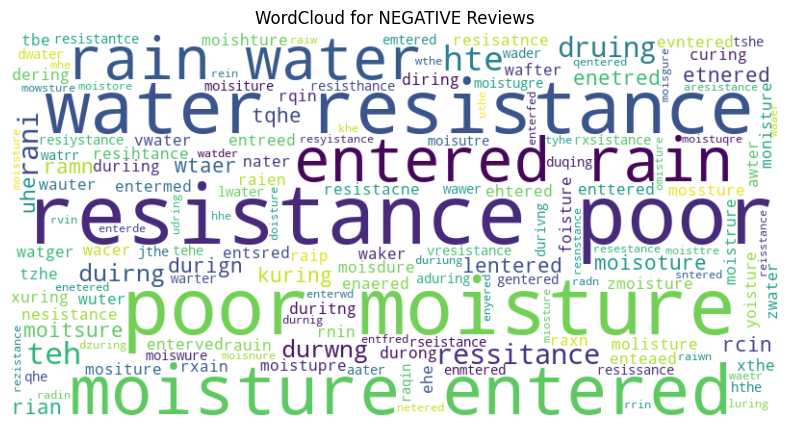

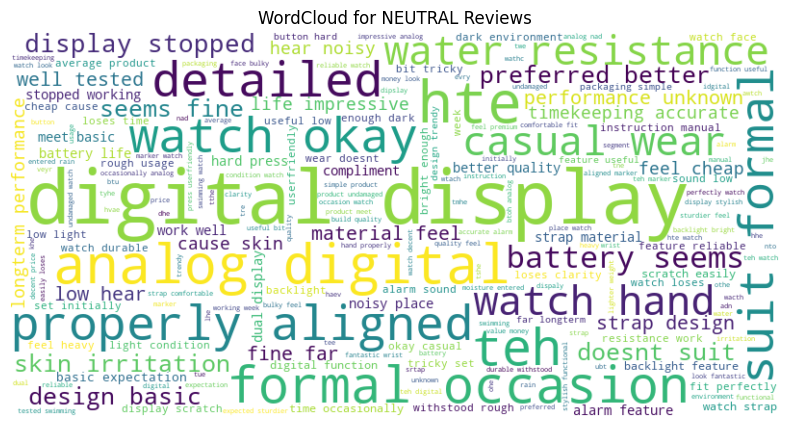

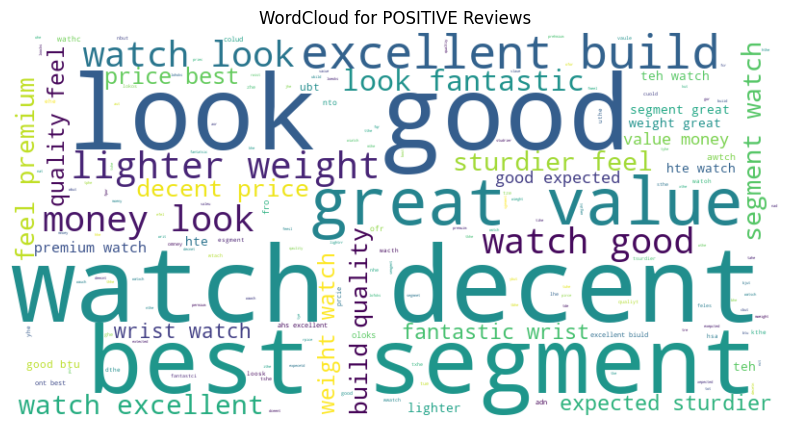


Final class mapping (showing only existing classes): {'negative': 0, 'neutral': 1, 'positive': 2}
Label distribution: {np.int64(0): np.int64(104), np.int64(1): np.int64(3437), np.int64(2): np.int64(511)}


In [ ]:
word_counts = Counter()
for review in df['cleaned_review']:
    word_counts.update(review.split())

vocab_size = 5000

vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def text_to_sequence(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

sequences = [text_to_sequence(review) for review in df['cleaned_review']]
existing_classes = df['sentiment'].unique()
sentiment_map = {
    'negative': 0,
    'neutral': 1, 
    'positive': 2
}

sentiment_map = {k:v for k,v in sentiment_map.items() if k in existing_classes}
df['sentiment_label'] = df['sentiment'].map(sentiment_map)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label, label_id in sentiment_map.items():
    text = " ".join(df[df['sentiment_label'] == label_id]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {label.upper()} Reviews")
    plt.show()

labels = df['sentiment_label'].values

print(f"\nFinal class mapping (showing only existing classes): {sentiment_map}")
print("Label distribution:", dict(sorted(zip(*np.unique(labels, return_counts=True)))))

if len(sentiment_map) < 2:
    raise ValueError(f"Only {len(sentiment_map)} class(es) detected. Need at least 2 for classification.")



In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

import random

In [ ]:
def flip_labels(y, noise_rate=0.5):
    y_noisy = y.copy()
    unique_labels = list(set(y))

    if len(unique_labels) < 2:
        print("Only one unique label found — cannot flip labels.")
        return y 
    num_noisy = int(len(y) * noise_rate)
    indices = np.random.choice(len(y), size=num_noisy, replace=False)

    for i in indices:
        original = y_noisy[i]
        alt_labels = [l for l in unique_labels if l != original]
        if alt_labels:
            new_label = random.choice(alt_labels)
            y_noisy[i] = new_label
    return y_noisy


labels = flip_labels(labels, noise_rate=0) 

X_train, X_temp, y_train, y_temp = train_test_split(sequences, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
import random
from nltk.corpus import wordnet

def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        synonyms = wordnet.synsets(words[idx])
        if synonyms:
            lemmas = synonyms[0].lemmas()
            if lemmas:
                new_words[idx] = lemmas[0].name()
    return ' '.join(new_words)

augmented_df = df.sample(frac=0.5, random_state=42).copy()
augmented_df['cleaned_review'] = augmented_df['cleaned_review'].apply(lambda x: synonym_replacement(x, 1))

df_augmented = pd.concat([df, augmented_df], ignore_index=True).reset_index(drop=True)

print("\nSplit sizes:")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Train labels:", np.unique(y_train, return_counts=True))
print("Val labels:", np.unique(y_val, return_counts=True))
print("Test labels:", np.unique(y_test, return_counts=True))

print("\nSample reviews:")
for sentiment, label in sentiment_map.items():
    sample = df[df['sentiment_label'] == label]['Review Text'].head(1)
    if not sample.empty:
        print(f"\n[{sentiment.upper()}] {sample.values[0]}")



Split sizes:
Train: 2836, Val: 608, Test: 608
Train labels: (array([0, 1, 2]), array([  73, 2405,  358]))
Val labels: (array([0, 1, 2]), array([ 15, 516,  77]))
Test labels: (array([0, 1, 2]), array([ 16, 516,  76]))

Sample reviews:

[NEGATIVE] The water resistance is poor, foisture enteaed dering rain.

[NEUTRAL] The watch hands arre nuot properly aligned with the markers.

[POSITIVE] The watch is decent ifor the prmice but aot the best in teh segment.


In [ ]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, torch.stack(labels)

batch_size = 64
train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ReviewDataset(X_val, y_val), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(ReviewDataset(X_test, y_test), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
class Classifier(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 100)  
        self.fc1 = nn.Linear(100, 50)  
        self.fc2 = nn.Linear(50, output_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, text):
        embedded = self.embedding(text).mean(dim=1)
        hidden = torch.relu(self.fc1(embedded))
        hidden = self.dropout(hidden)
        return self.fc2(hidden)

In [ ]:
embedding_dim = 100
hidden_dim = 128
n_layers = 1
dropout = 0.1
weight_decay = 1e-5
output_dim = len(sentiment_map)



model = Classifier(len(vocab), output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)


def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)

print("Unique labels in training set:", np.unique(y_train))


Unique labels in training set: [0 1 2]


In [ ]:
n_epochs = 10
best_valid_loss = float('inf')
patience = 6
epochs_no_improve = 3

for epoch in range(n_epochs):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += acc.item()

    
    model.eval()
    valid_loss, valid_acc = 0, 0
    
    with torch.no_grad():
        for batch in val_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            predictions = model(text)
            loss = criterion(predictions, labels)
            acc = categorical_accuracy(predictions, labels)
            valid_loss += loss.item()
            valid_acc += acc.item()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    valid_loss /= len(val_loader)
    valid_acc /= len(val_loader)

    print(f'\nEpoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement!")
            break

Epoch 1: 100%|██████████| 45/45 [00:00<00:00, 142.17it/s]



Epoch: 01
	Train Loss: 0.941 | Train Acc: 64.17%
	 Val. Loss: 0.698 |  Val. Acc: 85.16%


Epoch 2: 100%|██████████| 45/45 [00:00<00:00, 188.74it/s]



Epoch: 02
	Train Loss: 0.608 | Train Acc: 84.65%
	 Val. Loss: 0.542 |  Val. Acc: 85.16%


Epoch 3: 100%|██████████| 45/45 [00:00<00:00, 160.51it/s]



Epoch: 03
	Train Loss: 0.542 | Train Acc: 84.73%
	 Val. Loss: 0.510 |  Val. Acc: 85.16%


Epoch 4: 100%|██████████| 45/45 [00:00<00:00, 171.53it/s]



Epoch: 04
	Train Loss: 0.526 | Train Acc: 84.81%
	 Val. Loss: 0.497 |  Val. Acc: 85.16%


Epoch 5: 100%|██████████| 45/45 [00:00<00:00, 177.21it/s]



Epoch: 05
	Train Loss: 0.509 | Train Acc: 84.81%
	 Val. Loss: 0.487 |  Val. Acc: 85.16%


Epoch 6: 100%|██████████| 45/45 [00:00<00:00, 146.83it/s]



Epoch: 06
	Train Loss: 0.499 | Train Acc: 84.96%
	 Val. Loss: 0.478 |  Val. Acc: 85.16%


Epoch 7: 100%|██████████| 45/45 [00:00<00:00, 111.66it/s]



Epoch: 07
	Train Loss: 0.490 | Train Acc: 84.96%
	 Val. Loss: 0.470 |  Val. Acc: 85.16%


Epoch 8: 100%|██████████| 45/45 [00:00<00:00, 150.73it/s]



Epoch: 08
	Train Loss: 0.480 | Train Acc: 84.88%
	 Val. Loss: 0.463 |  Val. Acc: 85.16%


Epoch 9: 100%|██████████| 45/45 [00:00<00:00, 158.83it/s]



Epoch: 09
	Train Loss: 0.474 | Train Acc: 84.96%
	 Val. Loss: 0.456 |  Val. Acc: 85.16%


Epoch 10: 100%|██████████| 45/45 [00:00<00:00, 149.85it/s]


Epoch: 10
	Train Loss: 0.467 | Train Acc: 84.81%
	 Val. Loss: 0.449 |  Val. Acc: 85.16%


In [527]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_loss, test_acc = 0, 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        loss = criterion(predictions, labels)
        acc = categorical_accuracy(predictions, labels)
        test_loss += loss.item()
        test_acc += acc.item()

        all_preds.extend(predictions.argmax(dim=1).cpu().tolist())
        all_labels.extend(labels.cpu().tolist())


test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'\nTest Loss: {test_loss:.3f}| Test Acc: {test_acc*100:.2f}%')



Test Loss: 0.442| Test Acc: 85.00%



Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        16
     neutral       0.85      1.00      0.92       516
    positive       0.00      0.00      0.00        76

    accuracy                           0.85       608
   macro avg       0.28      0.33      0.31       608
weighted avg       0.72      0.85      0.78       608



c:\Users\lavz1\Desktop\gradious\miniproject2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lavz1\Desktop\gradious\miniproject2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\lavz1\Desktop\gradious\miniproject2\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

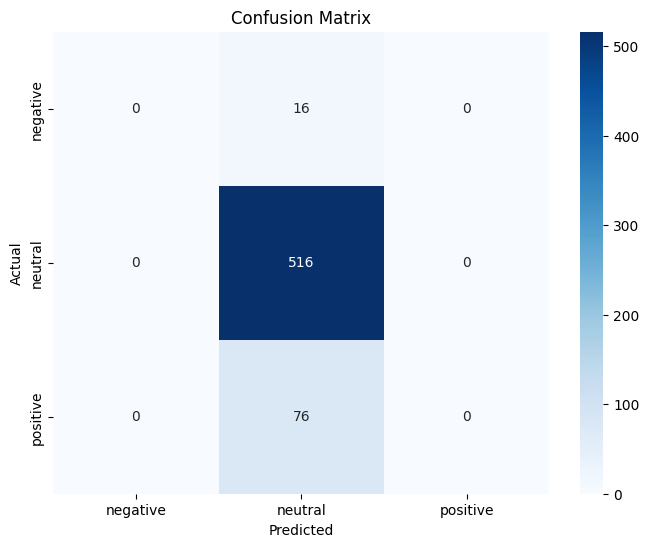

In [ ]:
class_names = list(sentiment_map.keys())
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()   
